In [1]:
from math import pi
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

    flatdelay是用于求解具有指定群延迟的transform function:1/D(z)的系数，论文《Low-Pass Filters Realizable as All-Pass Sums: Design via a New Flat Delay Filter》给出了closed-form形式的解，并给出了对应的程序

In [2]:
def flatdelay(K, L, t):
    N = K + L
    a = list(np.zeros(N+1))
    c = 1
    for i in range(L+1):
        n = list(range(i, N))
        v = list((n - np.full(len(n), N, dtype=int)) / (n - np.full(len(n), i-1, dtype=int))* 
                (np.full(len(n), 2*t, dtype=int) + n + np.full(len(n), i, dtype=int)) /
                (np.full(len(n), 2*t, dtype=int) + np.full(len(n), N+1, dtype=int) + n))
        v_copy = v.copy()
        a = np.array(a) + np.array(list(np.zeros(i)) + list(np.cumprod([c] + v_copy)))
        c = c*4*(t+i)*(L-i) / (2*t+N+1+i) / (i+1)
    return list(a)

interpolate——插值函数

In [3]:
def interpolate(array_ori, D):
    array_interp = []
    for index, i in enumerate(array_ori):
        if index < (len(array_ori) - 1):
            array_interp = array_interp + [i] + [0]*(D-1)
        else:
            array_interp = array_interp + [i]
    return array_interp

mfaps用于求解H(z) = (z^(-dD) + A(z))/2的系数, 其中A(z) = (z^-N * D(1/z))/D(z)。由flatdelay求出1/D(z)的系数后，不难得到H(z)的系数。

K——表示w=0的约束数量； L——表示w=pi的约束数量

d ——表示half-band形式中的延迟项 ；D——表示插值个数，若D=1则为half-band滤波器

K, L ,d 的应遵循如下设定标准：1. |K-L|+1 <= d <= K+L+1；
                     2. d must be same parity as K+L+1
                     
论文《Low-Pass Filters Realizable as All-Pass Sums: Design via a New Flat Delay Filter》给出了程序,这里多加入了插值的操作

In [4]:
def mfaps_lowpass_interp(K, L, d, D):
    b1 = ((abs(K-L)+1) <= d) and (d <= (K+L+1))
    b2 = ((K+L+1-d)%2 == 0)
    
    if (b1 and b2):
        a = flatdelay(K, L, (d-K-L)/2)
        a = interpolate(a, D)
        rts = np.roots(a)
        v = abs(rts) < 1
        v_not = abs(rts) >= 1

        v_logical = rts * v
        modified_v = np.delete(v_logical, np.where(v_logical == 0))

        v_logical_not = rts * v_not
        modified_v_not = np.delete(v_logical_not, np.where(v_logical_not == 0))

        a1 = np.real(np.poly(modified_v))
        a2 = np.real(np.poly(1/modified_v_not))
        
        p1 = list(np.zeros(d*D)) + a 
        p2 = a[::-1] + list(np.zeros(d*D))
        numerator = np.array(p2) + np.array(p1)
        denominator = 2 * np.convolve(a1, a2)
        return numerator, denominator
    else:
        print("For this K and L, d must be one of the following:")
        print("1. |K-L|+1 <= d <= K+L+1")
        print("2. d must be same parity as K+L+1")

In [5]:
def mfaps_highpass_interp(K, L, d, D):
    b1 = ((abs(K-L)+1) <= d) and (d <= (K+L+1))
    b2 = ((K+L+1-d)%2 == 0)
    
    if (b1 and b2):
        a = flatdelay(K, L, (d-K-L)/2)
        a = interpolate(a, D)
        rts = np.roots(a)
        v = abs(rts) < 1
        v_not = abs(rts) >= 1

        v_logical = rts * v
        modified_v = np.delete(v_logical, np.where(v_logical == 0))

        v_logical_not = rts * v_not
        modified_v_not = np.delete(v_logical_not, np.where(v_logical_not == 0))

        a1 = np.real(np.poly(modified_v))
        a2 = np.real(np.poly(1/modified_v_not))
        
        p1 = list(np.zeros(d*D)) + a 
        p2 = a[::-1] + list(np.zeros(d*D))
        numerator = np.array(p2) - np.array(p1)
        denominator = 2 * np.convolve(a1, a2)
        return numerator, denominator
    else:
        print("For this K and L, d must be one of the following:")
        print("1. |K-L|+1 <= d <= K+L+1")
        print("2. d must be same parity as K+L+1")

根据论文《Digital Filter Banks with Approximately Liner Phase》提出的结构，通过插值法设计mutliband滤波器

61
33
61
33


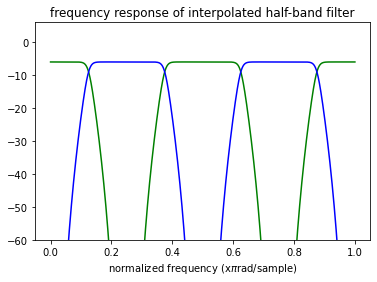

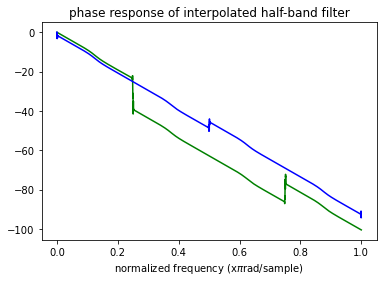

In [6]:
p_ori_low, q_ori_low = mfaps_lowpass_interp(4, 4, 7, 4)  # interpolated prototype filter
p_ori_high, q_ori_high = mfaps_highpass_interp(4, 4, 7, 4)

print(len(p_ori_low))
print(len(q_ori_low))
print(len(p_ori_high))
print(len(q_ori_high))

w_ori_low, h_ori_low = scipy.signal.freqz(p_ori_low, q_ori_low, 8192)
w_ori_high, h_ori_high = scipy.signal.freqz(p_ori_high, q_ori_high, 8192)

amplitude_lowpass = 20 * np.log10(abs(h_ori_low) / 2)
amplitude_highpass = 20 * np.log10(abs(h_ori_high) / 2)

angle_lowpass = np.angle(h_ori_low)
angle_highpass = np.angle(h_ori_high)

plt.figure(1)
plt.plot()
plt.title("frequency response of interpolated half-band filter")
plt.xlabel(r"normalized frequency (x$\pi$rad/sample)")
plt.plot(w_ori_low/max(w_ori_low), amplitude_lowpass, "g")
plt.plot(w_ori_low/max(w_ori_low), amplitude_highpass, "b")
plt.ylim(-60,6)
plt.show()

plt.figure(2)
plt.plot()
plt.title("phase response of interpolated half-band filter")
plt.xlabel(r"normalized frequency (x$\pi$rad/sample)")
plt.plot(w_ori_low/max(w_ori_low), np.unwrap(angle_lowpass), "g")
plt.plot(w_ori_low/max(w_ori_low), np.unwrap(angle_highpass), "b")
plt.show()

根据论文《Digital Filter Banks with Approximately Liner Phase》，设计frequency response masking filter(FRM)来提取出multiband滤波器中的不同频带，FRM也是一种half-band滤波器。

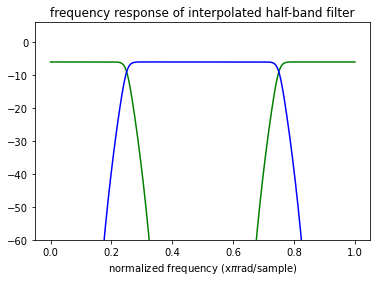

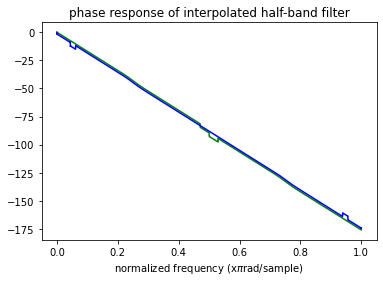

In [7]:
p_m1_low, q_m1_low = mfaps_lowpass_interp(14, 14, 27, 2)
p_m1_high, q_m1_high = mfaps_highpass_interp(14, 14, 27, 2)

w_m1_low, h_m1_low = scipy.signal.freqz(p_m1_low, q_m1_low, 8192)
w_m1_high, h_m1_high = scipy.signal.freqz(p_m1_high, q_m1_high, 8192)

amplitude_m1_low = 20 * np.log10(abs(h_m1_low) / 2)
amplitude_m1_high = 20 * np.log10(abs(h_m1_high) / 2)
angle_m1_low = np.angle(h_m1_low)
angle_m1_high = np.angle(h_m1_high)

plt.figure(1)
plt.plot()
plt.title("frequency response of interpolated half-band filter")
plt.xlabel(r"normalized frequency (x$\pi$rad/sample)")
plt.plot(w_m1_low/max(w_m1_low), amplitude_m1_low, "g")
plt.plot(w_m1_low/max(w_m1_low), amplitude_m1_high, "b")
plt.ylim(-60,6)
plt.show()

plt.figure(2)
plt.plot()
plt.title("phase response of interpolated half-band filter")
plt.xlabel(r"normalized frequency (x$\pi$rad/sample)")
plt.plot(w_m1_low/max(w_m1_low), np.unwrap(angle_m1_low), "g")
plt.plot(w_m1_low/max(w_m1_low), np.unwrap(angle_m1_high), "b")
plt.show()

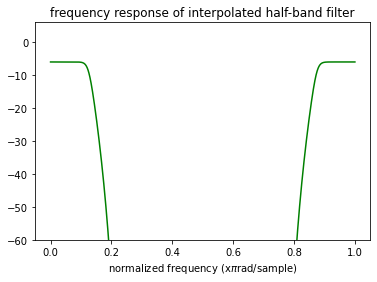

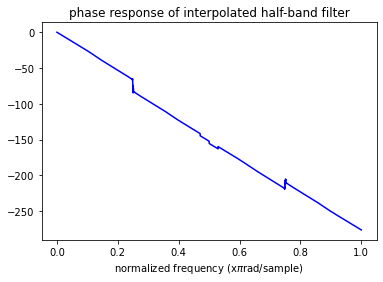

In [8]:
h_test = h_ori_low * h_m1_low

amplitude = 20 * np.log10(abs(h_test) / 2)
angle = np.angle(h_test)

plt.figure(1)
plt.plot()
plt.title("frequency response of interpolated half-band filter")
plt.xlabel(r"normalized frequency (x$\pi$rad/sample)")
plt.plot(w_m1_low/max(w_m1_low), amplitude, "g")
plt.ylim(-60,6)
plt.show()

plt.figure(2)
plt.plot()
plt.title("phase response of interpolated half-band filter")
plt.xlabel(r"normalized frequency (x$\pi$rad/sample)")
plt.plot(w_m1_low/max(w_m1_low), np.unwrap(angle), "b")
plt.show()


h_m2需要过渡带尽可能地陡峭，因此阶数比较高

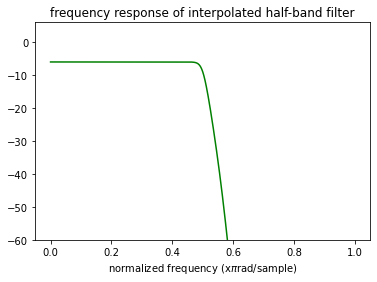

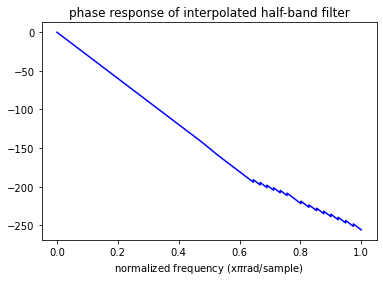

In [9]:
p_m2_low, q_m2_low = mfaps_lowpass_interp(48, 48, 95, 1)
p_m2_high, q_m2_high = mfaps_highpass_interp(48, 48, 95, 1)

w_m2_low, h_m2_low = scipy.signal.freqz(p_m2_low, q_m2_low, 8192)
w_m2_high, h_m2_high = scipy.signal.freqz(p_m2_high, q_m2_high, 8192)

amplitude = 20 * np.log10(abs(h_m2_low) / 2)
angle = np.angle(h_m2_low)

plt.figure(1)
plt.plot()
plt.title("frequency response of interpolated half-band filter")
plt.xlabel(r"normalized frequency (x$\pi$rad/sample)")
plt.plot(w_m1_low/max(w_m1_low), amplitude, "g")
plt.ylim(-60,6)
plt.show()

plt.figure(2)
plt.plot()
plt.title("phase response of interpolated half-band filter")
plt.xlabel(r"normalized frequency (x$\pi$rad/sample)")
plt.plot(w_m1_low/max(w_m1_low), np.unwrap(angle), "b")
plt.show()

通过串联一系列的 interpolated half-band filter来划分不同的频带

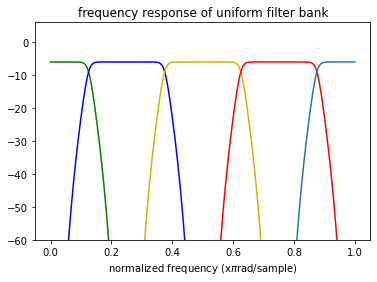

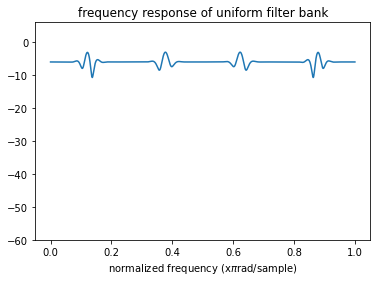

In [10]:
channel_1 = h_ori_low * h_m1_low * h_m2_low 
channel_5 = h_ori_low * h_m1_low * h_m2_high
channel_3 = h_ori_low * h_m1_high
channel_2 = h_ori_high * h_m2_low
channel_4 = h_ori_high * h_m2_high

channel_all = channel_1 + channel_2 + channel_3 + channel_4 +channel_5

amplitude_1 = 20 * np.log10(abs(channel_1) / 2)
amplitude_2 = 20 * np.log10(abs(channel_2) / 2)
amplitude_3 = 20 * np.log10(abs(channel_3) / 2)                            
amplitude_4 = 20 * np.log10(abs(channel_4) / 2)
amplitude_5 = 20 * np.log10(abs(channel_5) / 2)                           
amplitude_all = 20 * np.log10(abs(channel_all) / 2)  

                            
plt.figure(1)
plt.plot()
plt.title("frequency response of uniform filter bank")
plt.xlabel(r"normalized frequency (x$\pi$rad/sample)")
plt.plot(w_ori_low/max(w_ori_low), amplitude_1, "g")
plt.plot(w_ori_low/max(w_ori_low), amplitude_2, "b")
plt.plot(w_ori_low/max(w_ori_low), amplitude_3, "y")
plt.plot(w_ori_low/max(w_ori_low), amplitude_4, "r")
plt.plot(w_ori_low/max(w_ori_low), amplitude_5)      
plt.ylim(-60,6)
plt.show()

plt.figure(2)
plt.plot()
plt.title("frequency response of uniform filter bank")
plt.xlabel(r"normalized frequency (x$\pi$rad/sample)")
plt.plot(w_ori_low/max(w_ori_low), amplitude_all)        
plt.ylim(-60,6)
plt.show()